# StatsLib Demo

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

In [3]:
from copy import deepcopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import statsmodels.api as sm

In [5]:
import statslib as stb

In [6]:
pa = stb.utils.common.print_attributes
ddff = stb.utils.dframe.display_full_df

In [7]:
figsize = (8*1.6, 8)

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Data Sets

In [9]:
y = stb.datasets.stocks.df.A

In [10]:
X = stb.datasets.stocks.df.drop('A', axis=1)

# Design Matrix

**For ARIMA-type models we have to provide time-index frequency**

In [11]:
try:
    y.index.freq = 'D'
except Exception as e:
    print(e.args[0])

Inferred frequency None from passed values does not conform to passed frequency D


In [12]:
try:
    X.index.freq = 'D'
except Exception as e:
    print(e.args[0])

Inferred frequency None from passed values does not conform to passed frequency D


## Imputations

In [13]:
y = y.resample('D').mean().fillna(method='ffill')

In [14]:
X = X.resample('D').mean().fillna(method='ffill')

$$
\begin{align}
t\ | \ y_t \xrightarrow{f} v_t, | \ \ x^1_t, \ x^2_t, \ \ldots \ x^k_t \xrightarrow{g} \ g_1x^1_t, \ g_2x^2_t, \ldots, g_kx^k_t
\end{align}
$$

$$
\text{DM}_t = \text{DM}_t(y_t, f, f^{-1}, \{x^i_t\}_{i=1,k}, \{g^i_t\}_{i=1,k})
$$

In [15]:
f = stb.transforms.pct_change(1)

In [16]:
X['Lag1ABT'] = X['ABT'].shift(1)

In [17]:
X['Lag2ABT'] = X['ABT'].shift(2)

In [18]:
g1 = stb.transforms.pct_change(1)

In [19]:
g2 = stb.transforms.difference_operator(1,1,3, inv_specification=[[-1, -1, 1], [1, 3, 4]])

In [20]:
g3 = stb.transforms.log_return(3)

In [21]:
g4 = g5 = lambda s: s

***

In [22]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=[g1, g2, g3, g4, g5])

## Exploratory analsis of Design Matrix

* Autocorrelation:
    * $ \text{ACF}(x_t) $
    * $ \text{PACF}(x_t) $


* Scatter Plots:
    * $y_t$ next to  $v_t$  and $x_t^{k}$ next to $g_kx^k_t$
    * $y_t \ \text{vs.} \ x^j_{t} $ for $j=1,k$ with LOWESS for dependency shape analysis
    * $x_t \ \text{vs.} \ x_{t-h}$ with LOWESS for autocorrelation analysis
    * $y_t \ \text{vs.} \ x^k_{t-h}$ for given $k$ with LOWESS for lagged-leading relationship

In [23]:
DM.dm_ext.head(5)

,A,v,ABC,ABMD,ABT,Lag1ABT,Lag2ABT,g1,g2,g3,g4,g5,const
t,,,,,,,,,,,,,
2018-12-18,67.989998,NaN,76.239998,304.799988,70.080002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2018-12-19,66.830002,-0.017061,76.309998,296.140015,69.000000,70.080002,NaN,0.000918,NaN,NaN,70.080002,NaN,1.0
2018-12-20,65.190002,-0.024540,73.220001,284.279999,68.379997,69.000000,70.080002,-0.040493,NaN,NaN,69.000000,70.080002,1.0
2018-12-21,63.290001,-0.029146,71.980003,290.290008,67.269997,68.379997,69.000000,-0.016935,NaN,-0.040923,68.379997,69.000000,1.0
2018-12-22,63.290001,0.000000,71.980003,290.290008,67.269997,67.269997,68.379997,0.000000,8.659973,-0.025392,67.269997,68.379997,1.0


In [24]:
DM.dm.head(5)

,y,v,g1,g2,g3,g4,g5,const
t,,,,,,,,
2018-12-22,63.290001,0.000000,0.000000,8.659973,-0.025392,67.269997,68.379997,1.0
2018-12-23,63.290001,0.000000,0.000000,11.860016,-0.016366,67.269997,67.269997,1.0
2018-12-24,62.669998,-0.009796,-0.016949,-15.220032,-0.025749,67.269997,67.269997,1.0
2018-12-25,62.669998,0.000000,0.000000,0.000000,-0.025749,65.559998,67.269997,1.0
2018-12-26,65.540001,0.045795,0.032222,26.360016,0.034338,65.559998,65.559998,1.0


In [25]:
DM.gX.head()

,const,g1,g2,g3,g4,g5
t,,,,,,
2018-12-22,1.0,0.000000,8.659973,-0.025392,67.269997,68.379997
2018-12-23,1.0,0.000000,11.860016,-0.016366,67.269997,67.269997
2018-12-24,1.0,-0.016949,-15.220032,-0.025749,67.269997,67.269997
2018-12-25,1.0,0.000000,0.000000,-0.025749,65.559998,67.269997
2018-12-26,1.0,0.032222,26.360016,0.034338,65.559998,65.559998


### Simple statistics

,A,ABC,ABMD,ABT,Lag1ABT,Lag2ABT
count,366.000000,366.000000,366.000000,366.000000,365.000000,364.000000
mean,74.414618,82.249727,253.310956,79.799604,79.780068,79.760069
std,4.969090,5.001473,58.325669,5.469843,5.464551,5.458680
min,62.669998,70.760002,159.309998,65.559998,65.559998,65.559998
25%,69.954998,78.327499,192.099998,76.290001,76.260002,76.250002
50%,75.389999,83.450001,260.480011,80.739998,80.739998,80.639999
75%,78.260002,86.129997,290.290008,84.269997,84.269997,84.262501
max,84.809998,91.699997,362.250000,88.739998,88.739998,88.739998


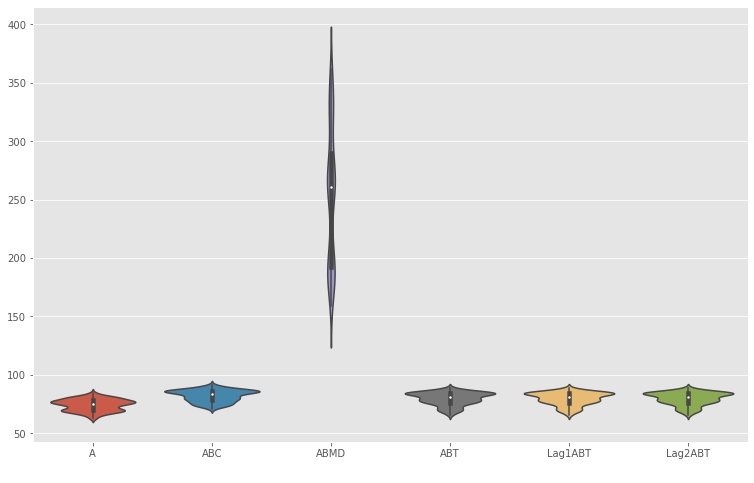

In [75]:
DM.describe()

,v,g1,g2,g3,g4,g5
count,365.000000,365.000000,362.000000,363.000000,365.000000,364.000000
mean,0.001910,0.001148,0.026713,0.001878,79.780068,79.760069
std,0.052205,0.042494,43.855078,0.065411,5.464551,5.458680
min,-0.203550,-0.138637,-211.830002,-0.259658,65.559998,65.559998
25%,-0.005123,-0.007004,-8.934998,-0.015123,76.260002,76.250002
50%,0.000000,0.000000,0.000000,0.004665,80.739998,80.639999
75%,0.009810,0.008459,7.782505,0.024465,84.269997,84.262501
max,0.295085,0.166235,206.509995,0.182774,88.739998,88.739998


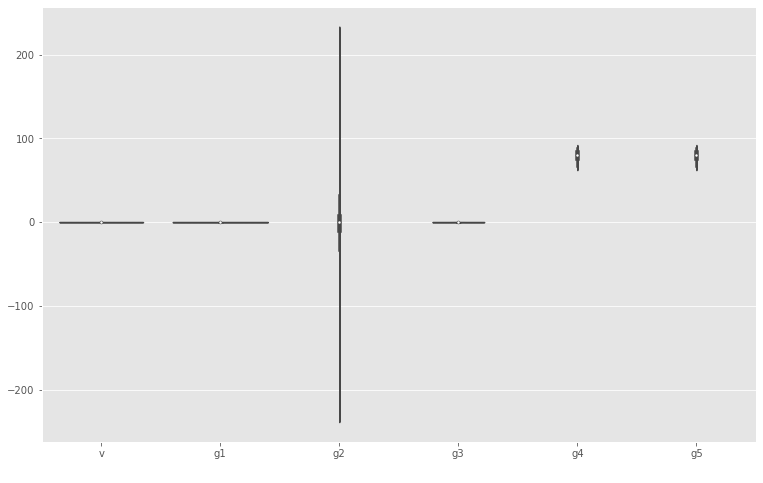

In [76]:
DM.describe(g_form=True)

### Let's see trend / seasonal decomposition (STL)

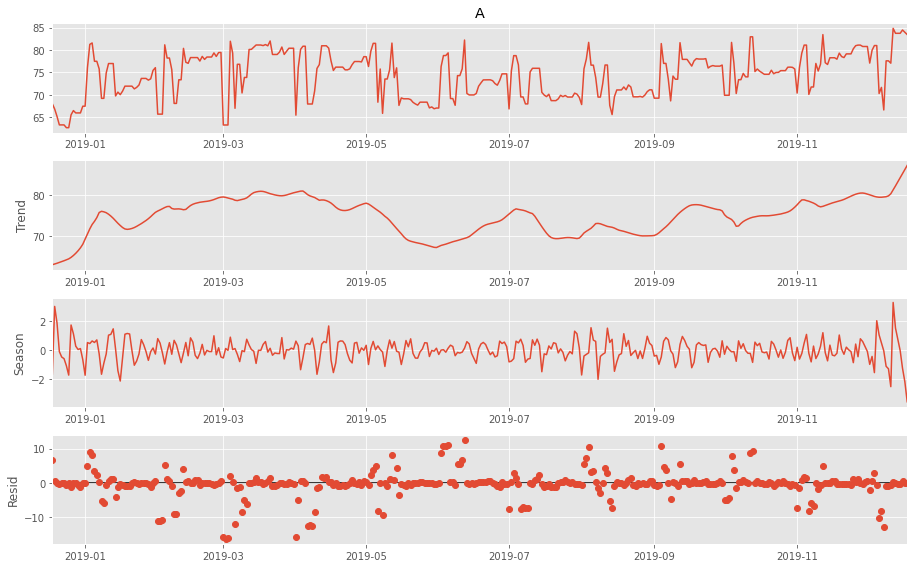

In [28]:
results = DM.seasonal_decompose(robust=True)

### Let's analysize residuals after decomposition

In [29]:
residuals = results.resid

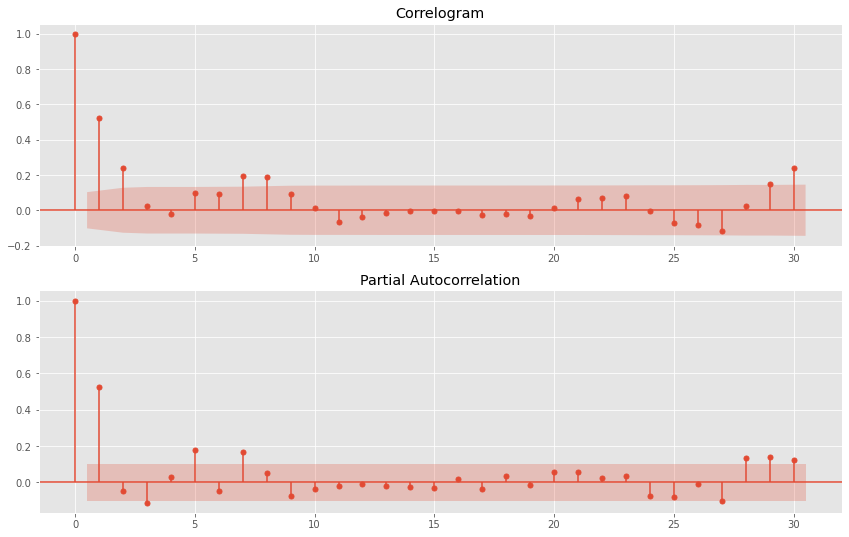

In [30]:
stb.stat_plots.plot_acf_pcf(residuals)

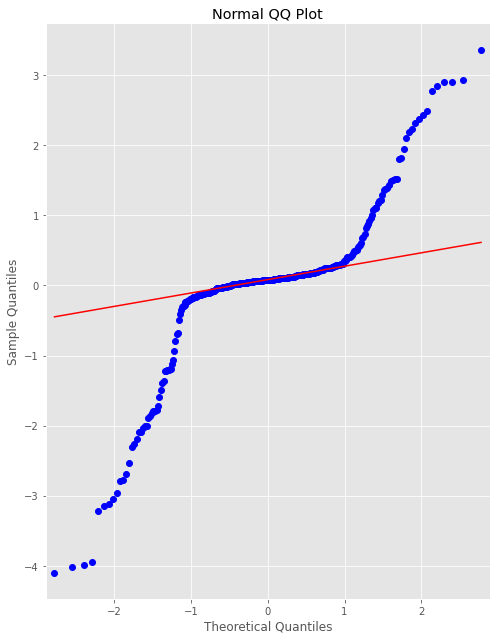

In [31]:
stb.stat_plots.plot_qq_plot(residuals)

### Let's plot $y_t$ vs. $v$ and $x^k_t$ vs. $g^kx_{t}$ relationship

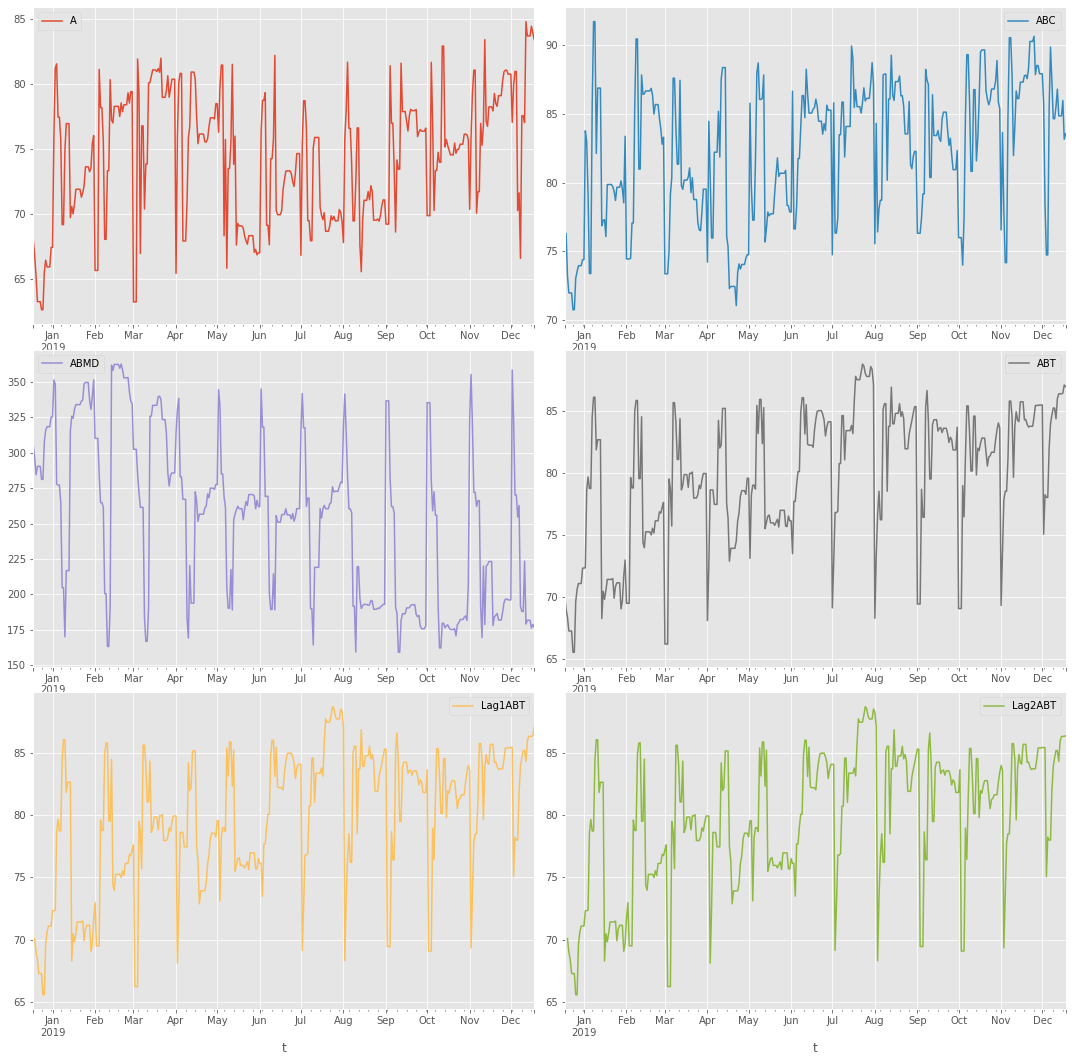

In [32]:
DM.plot()

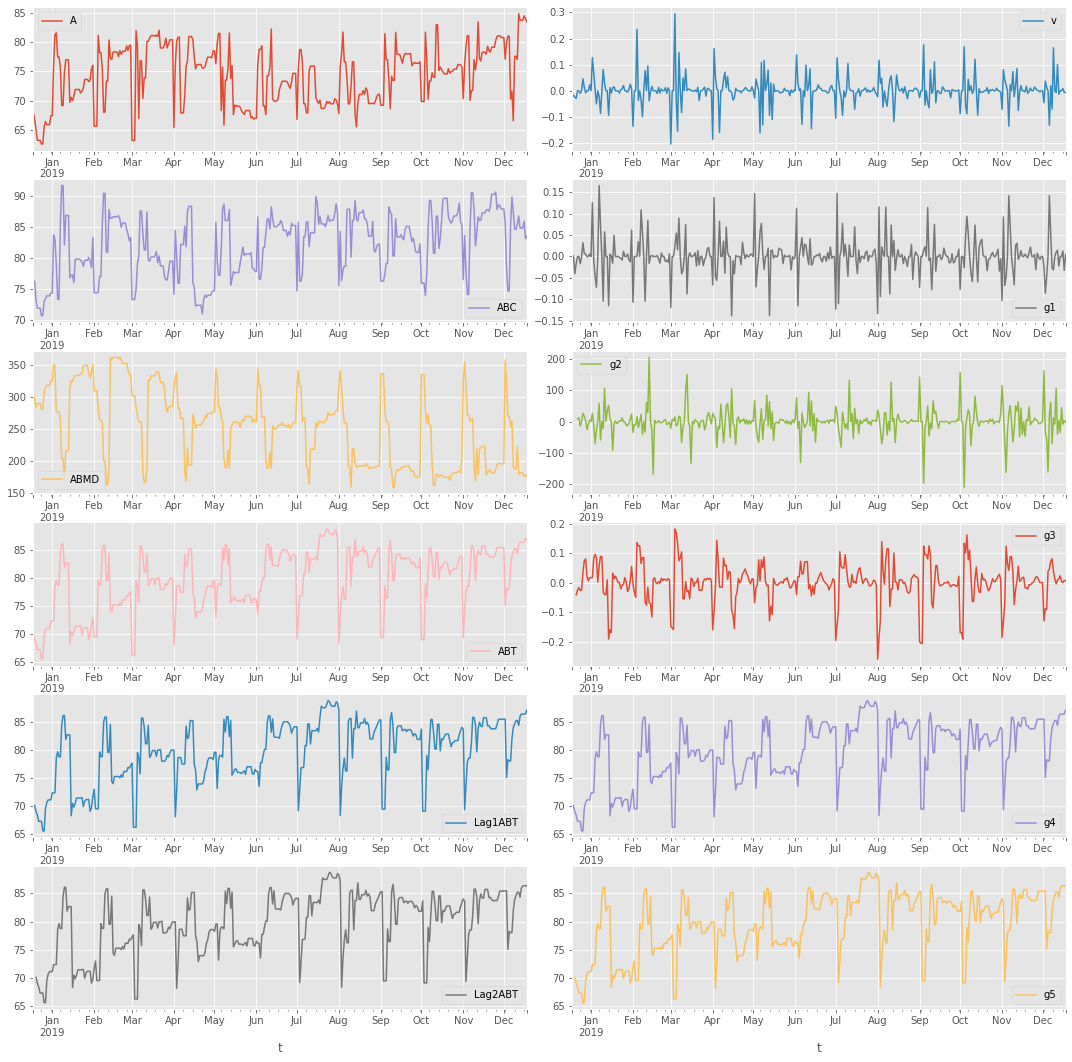

In [33]:
DM.plot(g_form=True)

### Let's plot $y_t$ vs $x^k_t$ relationship to see the plausible shape of functional dependency

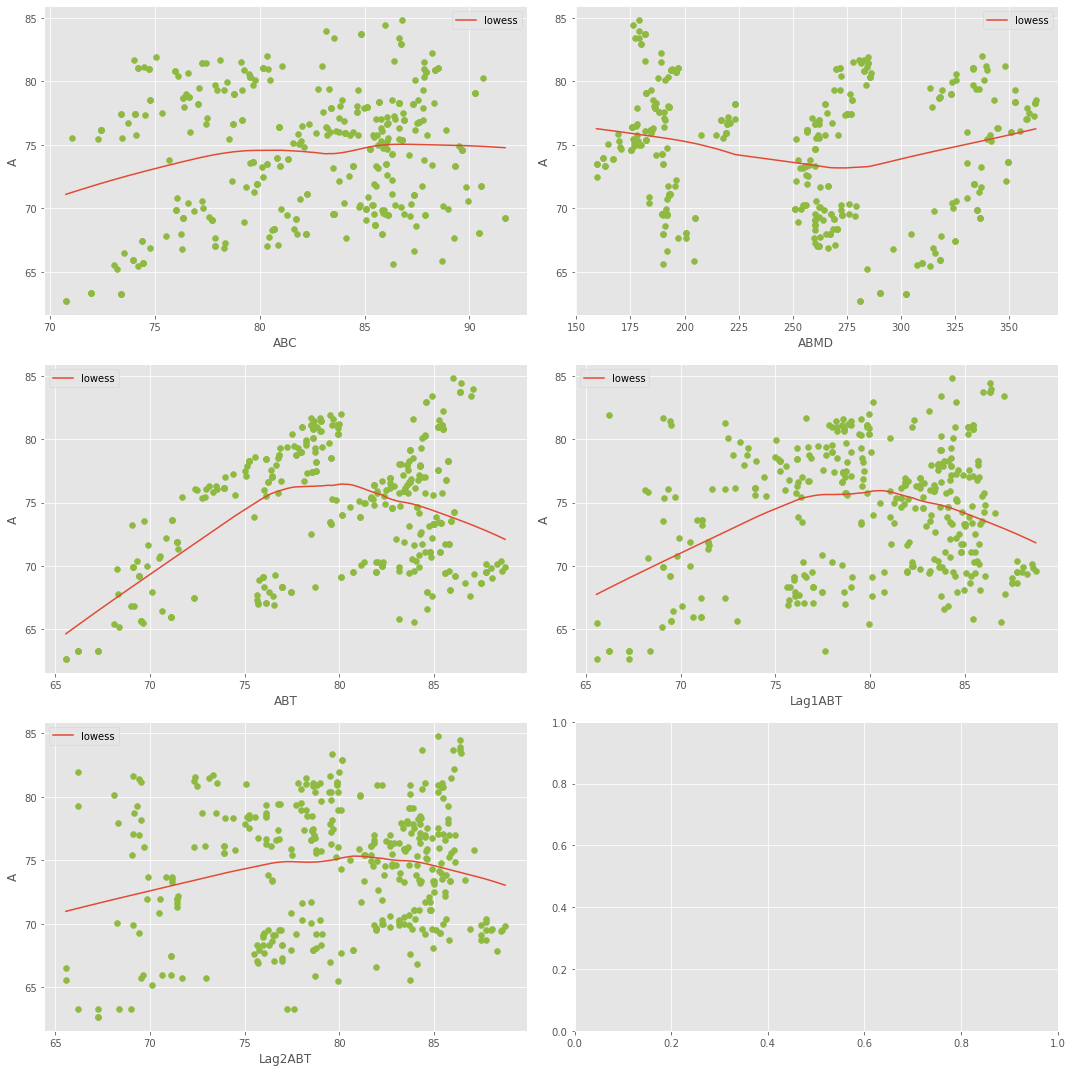

In [34]:
DM.plot_scatter_lowess()

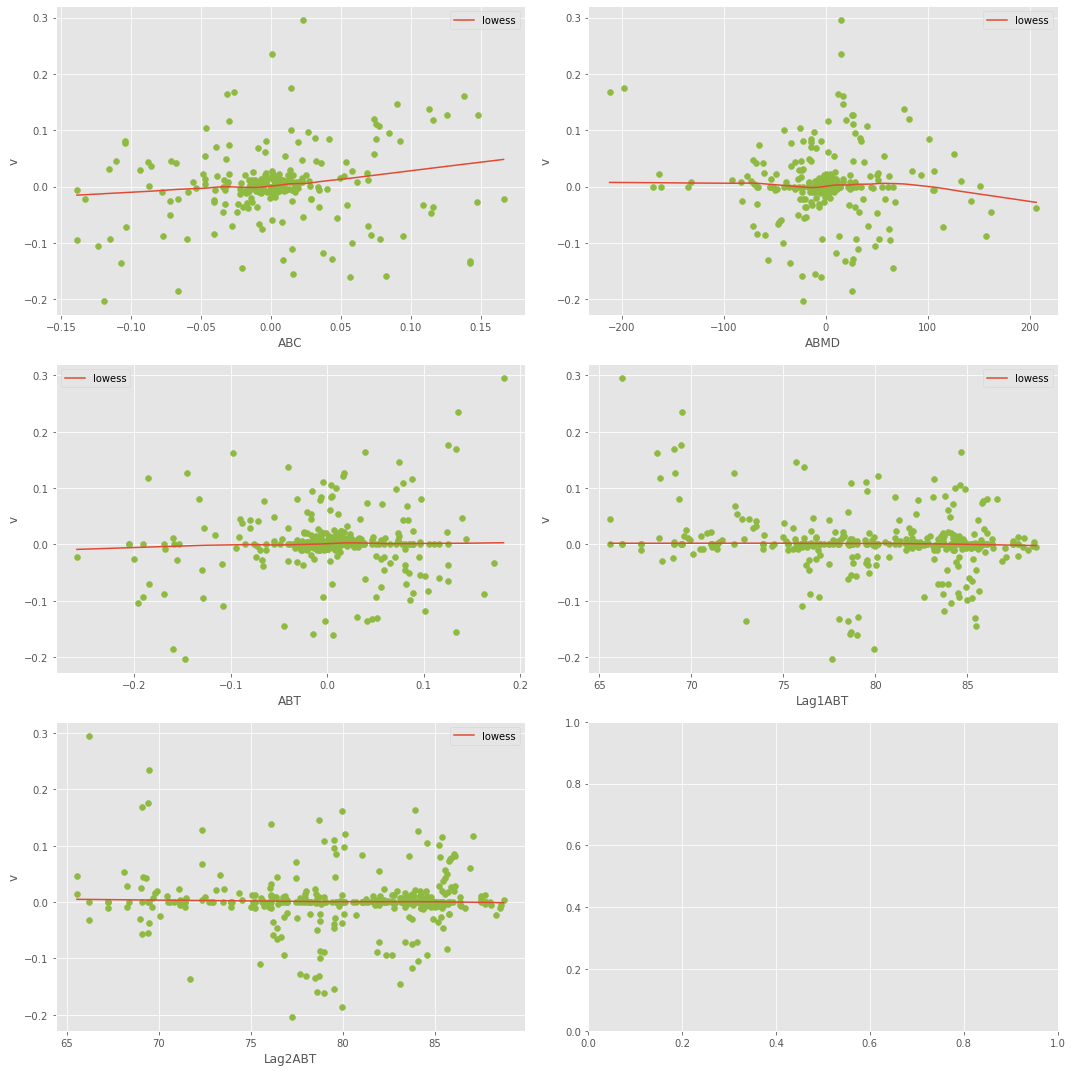

In [35]:
DM.plot_scatter_lowess(g_form=True)

### Plot Autocorrelation and Partial AutoCorrelation for a given covariate

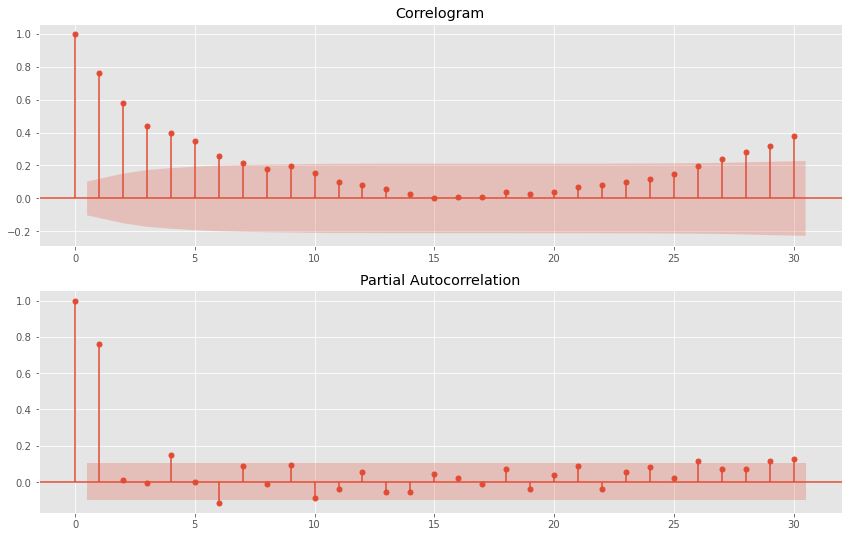

In [36]:
stb.stat_plots.plot_acf_pcf(DM.dm_ext.ABC)

### Let 's plot $x^k_t$ vs $x^k_{t-h}$ relationship for a given covariate $k$ as another way to demonstrate the autocorrelation.

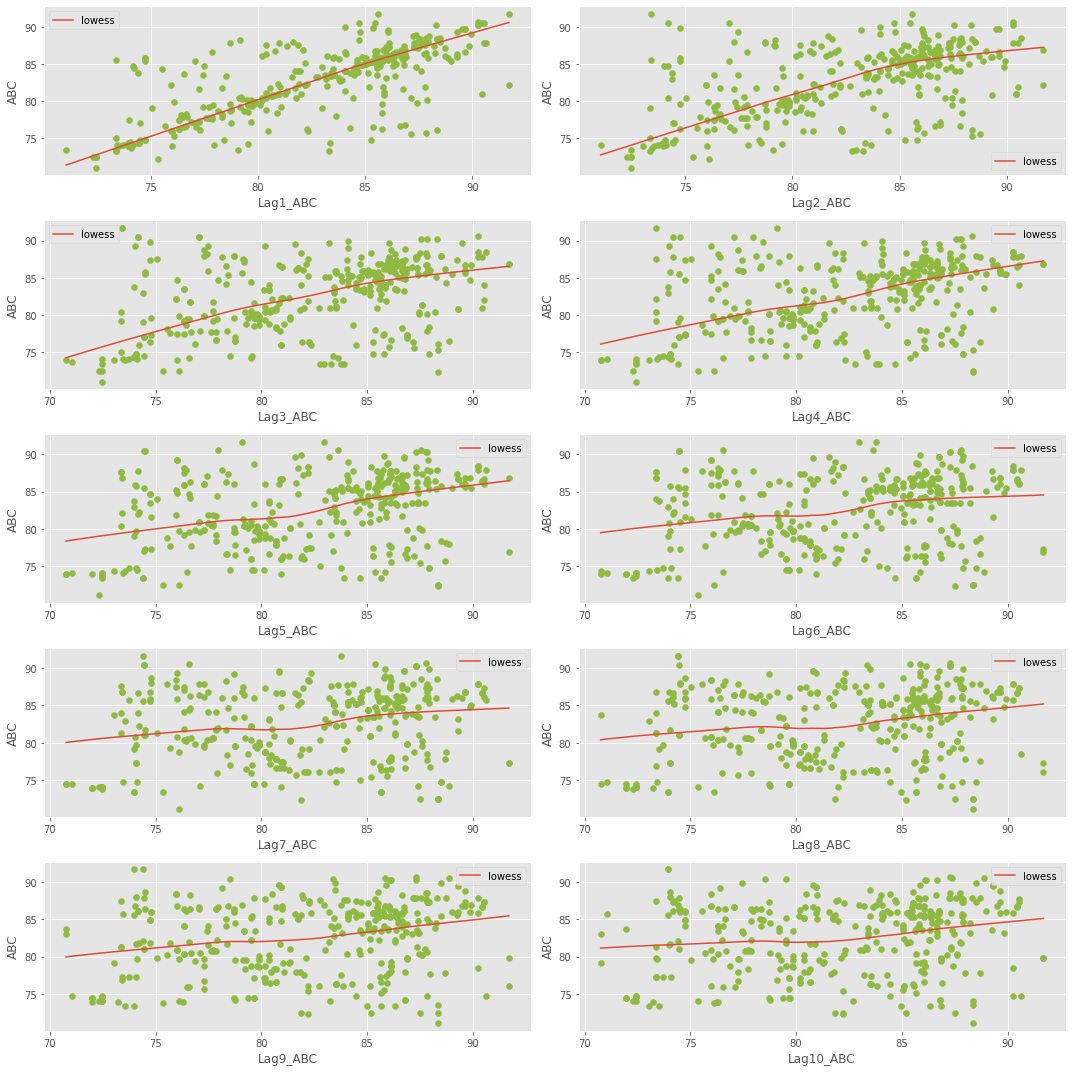

In [37]:
DM.plot_covariate_vs_lag(covariate_name='ABC', up_to_lag=10)

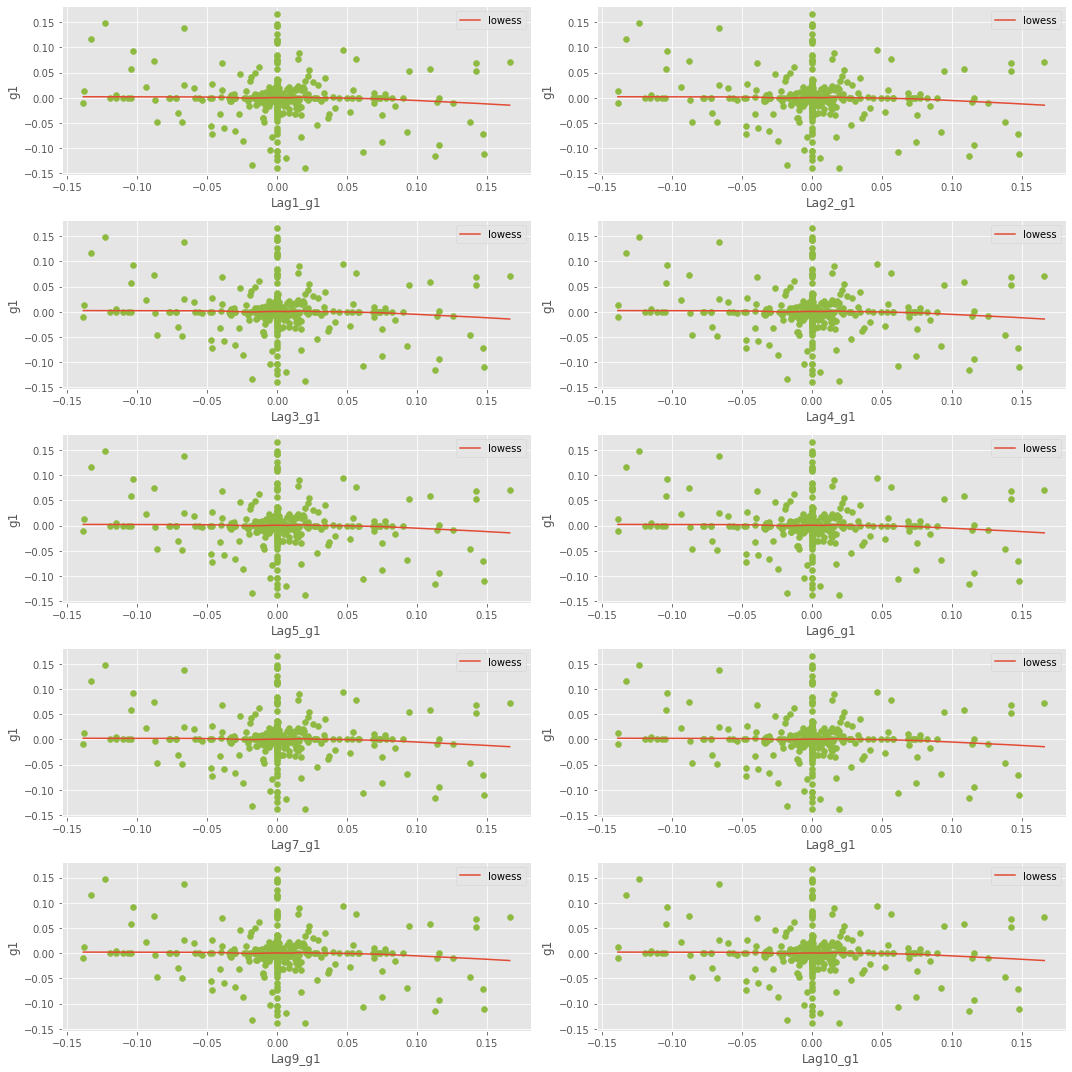

In [38]:
DM.plot_covariate_vs_lag(covariate_name='ABC', up_to_lag=10, g_form=True)

### Let 's plot $y_t$ vs $x^k_{t-h}$ relationship for a given covariate $k$ to see if there is a lead-lag relationship

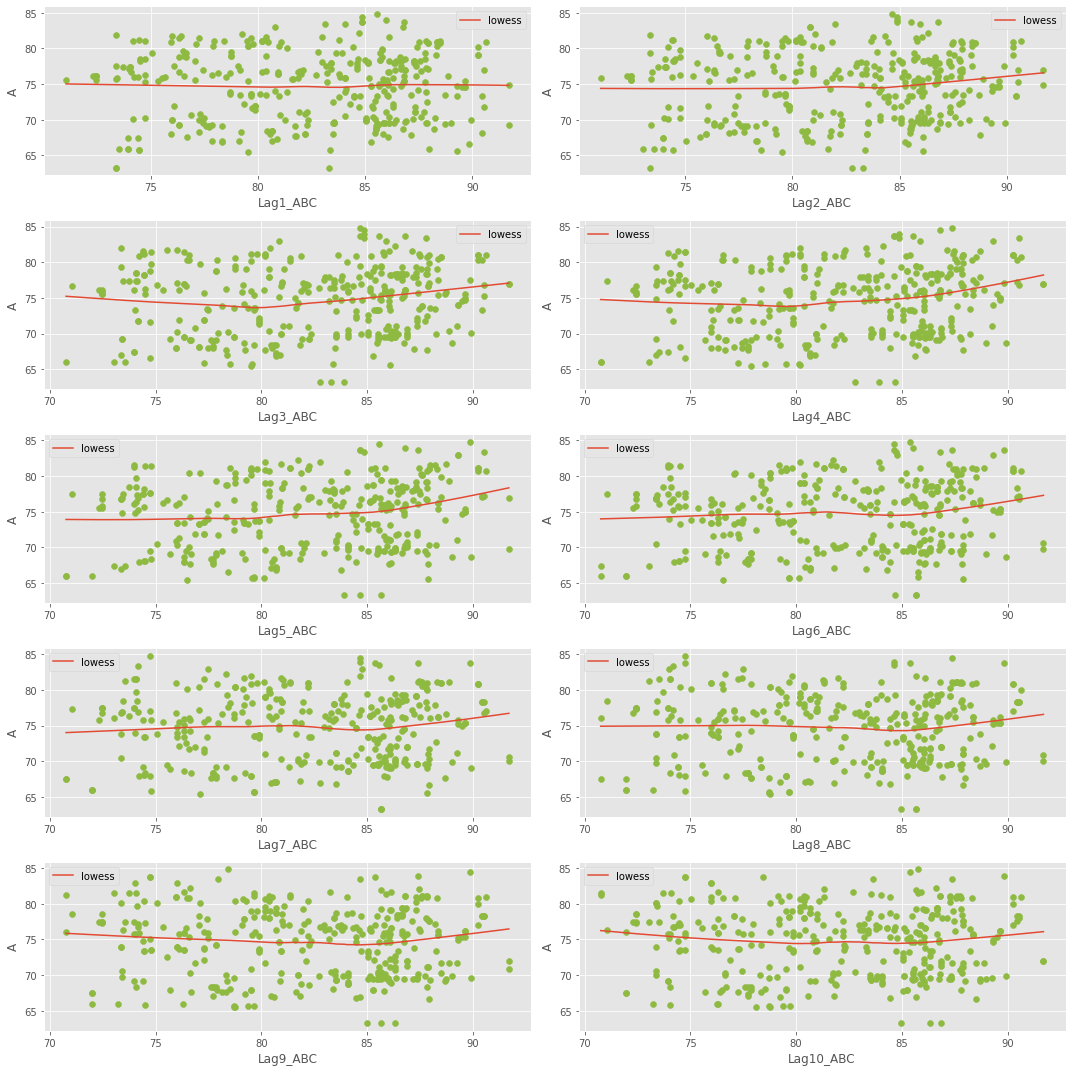

In [39]:
DM.plot_dependent_vs_covariage_lag('ABC', up_to_lag=10)

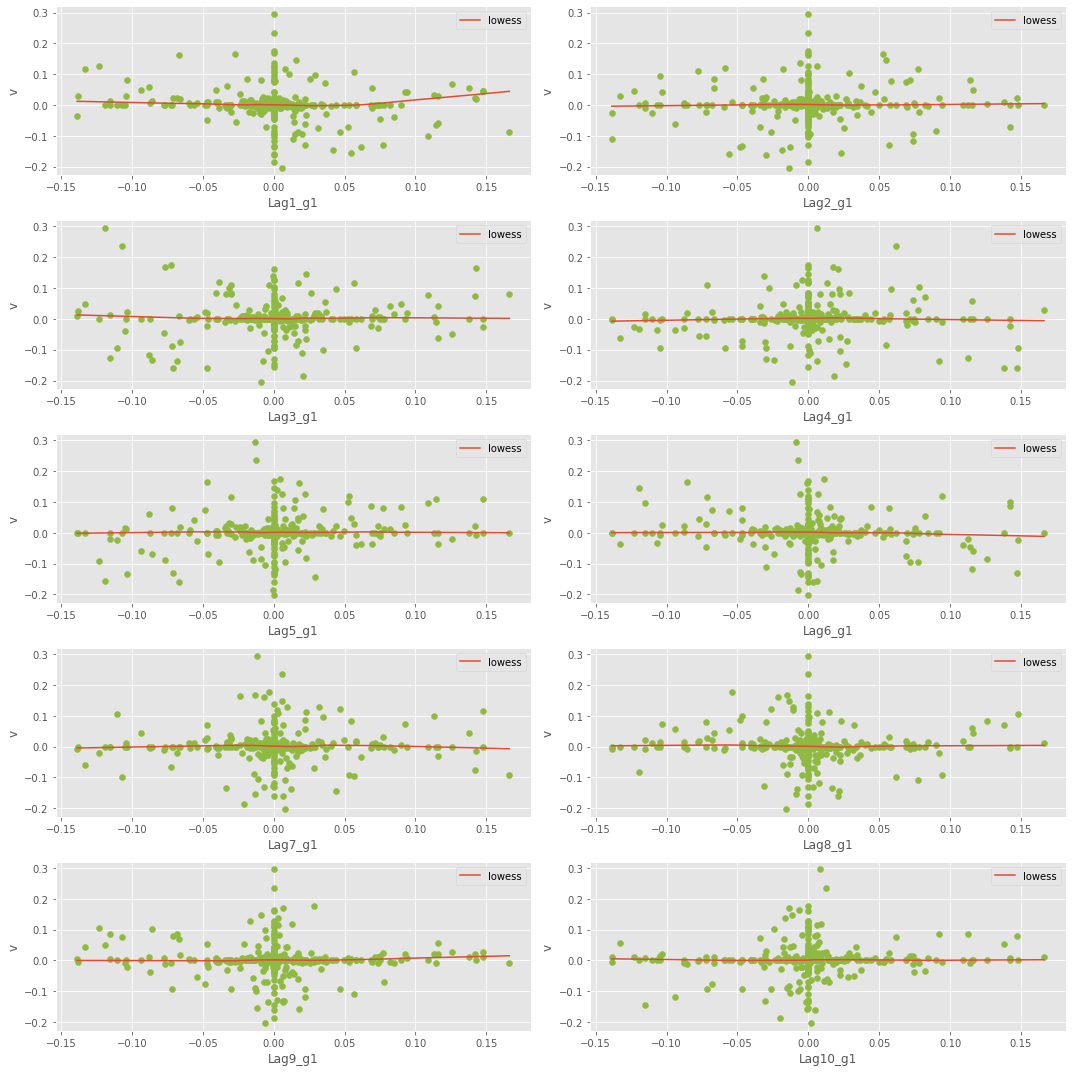

In [40]:
DM.plot_dependent_vs_covariage_lag('ABC', up_to_lag=10, g_form=True)

## Calibrator:

$$
 \mathbb{C} ( {\mathcal{H}yperParams}) \rightarrow \mathbb{C}
$$

## Model:
$$
\text{M} = \mathbb{M}(\text{C}, \ \text{DM} ) \to  \{\hat{\theta}_l\}_{l=1,m} 
$$

### Model Specification

$$
\{\hat{\theta}_l\} \xrightarrow[\text{GridSearch}]{I(\theta): \ AIC, \ AICc, \ BIC }  \{\hat{\theta^*_l}\}
$$

#### Grid search for model parameters

**for ARIMAX:**

In [41]:
from itertools import product

grid = product(range(1,3), [0], range(1,3))

results = []
for elem in grid:
    
        gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                                       dict(order=elem, 
                                       trend='n', 
                                       enforce_stationarity=True))
        gm = stb.GeneralModel(gc, DM)
        gm.fit(range(DM.n))
        results.append([elem, gm.fitted.aic])
    

pd.DataFrame(results, columns=['elem', 'aic']).sort_values(by=['aic'], ascending=True)

,elem,aic
1,"(1, 0, 2)",-1174.770214
0,"(1, 0, 1)",-1141.325325
3,"(2, 0, 2)",-1098.088149
2,"(2, 0, 1)",-1036.159144


**for OLS:**

In [42]:
from itertools import product

from functools import partial
powerset = partial(stb.utils.common.powerset, skip_empty_set=True)

nms = DM.x_to_g(DM.exog_names)
grid = product(['const'], powerset(nms))
results = []
for elem in grid:
    try:
        c, v = elem
        nm = [c] + list(v)
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(DM.dm.shape[0]))
        results.append([elem, gm.fitted.bic, nm])
    except:
        continue
pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']].head(5)

,config,metric
24,"[const, g3, g4, g5]",-1135.875217
28,"[const, g1, g3, g4, g5]",-1130.109229
29,"[const, g2, g3, g4, g5]",-1130.012929
30,"[const, g1, g2, g3, g4, g5]",-1124.221692
14,"[const, g4, g5]",-1116.165751


# Cross Validation:

$$
\text{CV} = \mathbb{CV}(\text{M}, \text{Partitioning}, \text{ Performance Metric}) 
$$

$$
\mathbb{C} \xrightarrow{\varepsilon_{CV}} \mathbb{C}^*
$$

### Train Test Splits

In [43]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
splits = [(train_idx, test_idx)for train_idx, test_idx in tscv.split(DM.dm.index)]

In [44]:
metric = stb.metrics.mean_absolute_percentage_error

## Different calibrators: 

### ARIMAX

CV_error: 0.16, CV_std: 0.07 | (0.09  0.24)


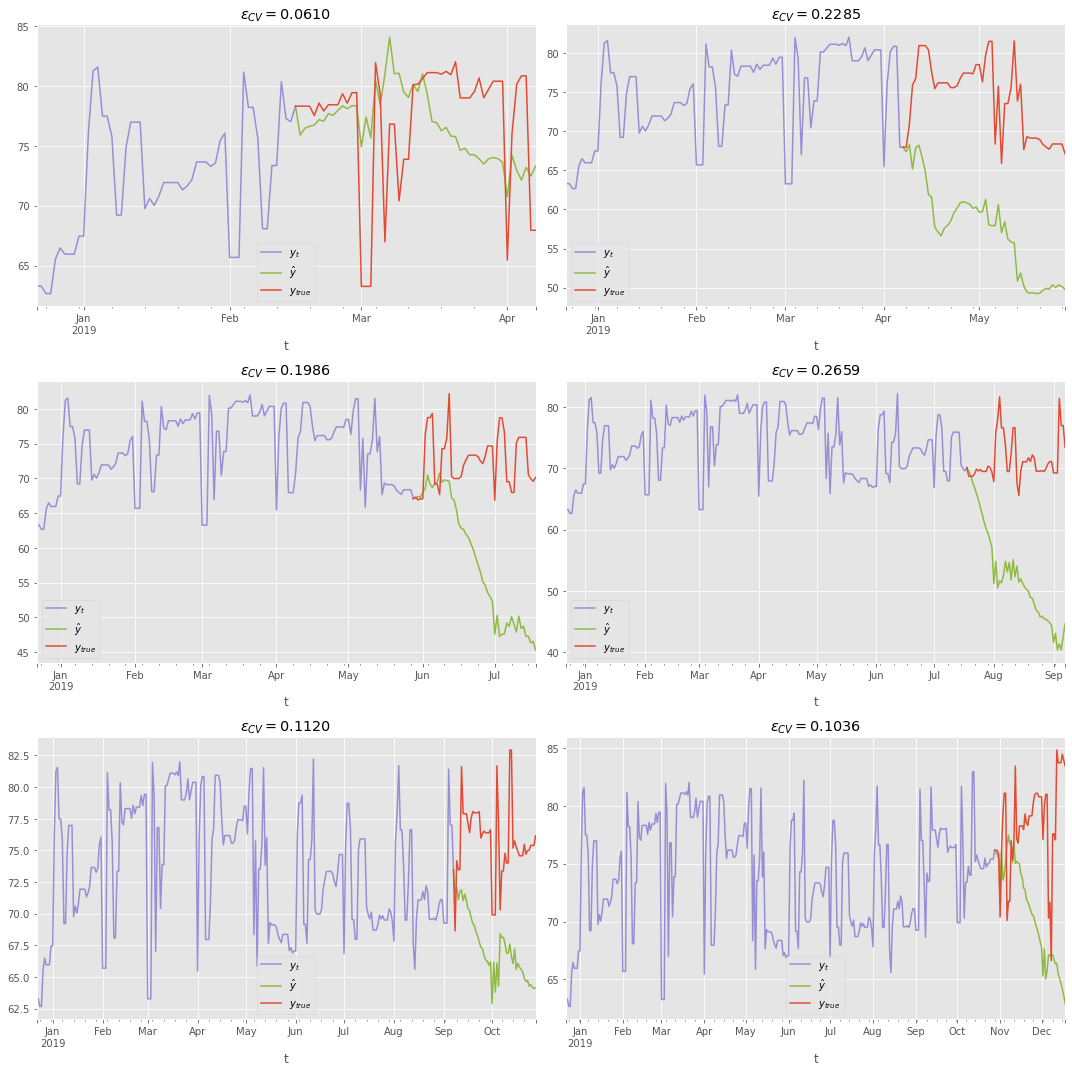

In [45]:
gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                               dict(order=(1,0,1), 
                               trend='n', 
                               enforce_stationarity=True))
gm = stb.GeneralModel(gc, DM)
cv = stb.CrossValidation(gm, splits, metric=metric)
cv_m, cv_std = cv.run()

### OLS

CV_error: 0.15, CV_std: 0.06 | (0.09  0.21)


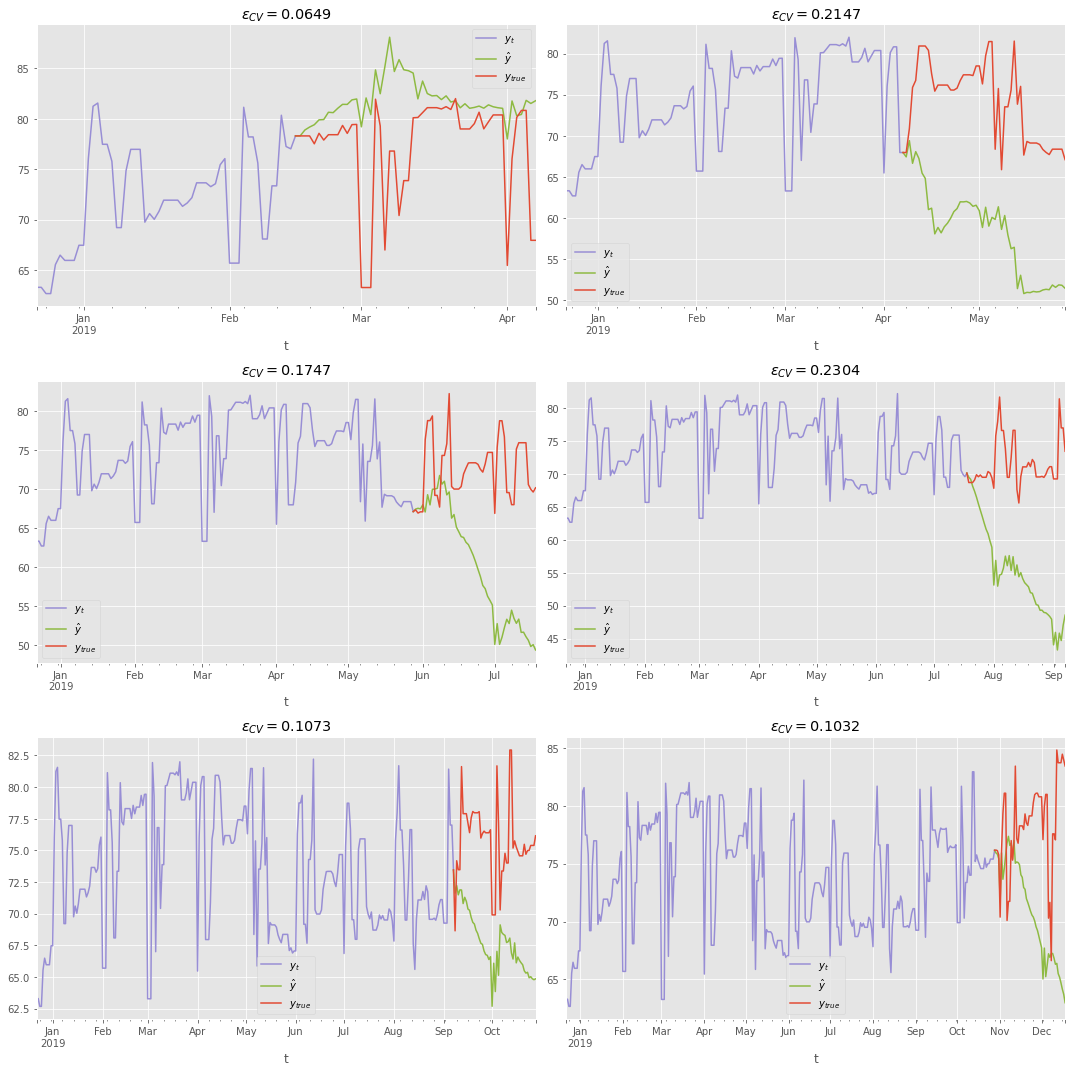

In [46]:
gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)
nm = ['const','g3', 'g4', 'g5']
nDM.gX = nDM.gX[nm]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

### RLM

CV_error: 0.09, CV_std: 0.04 | (0.05  0.12)


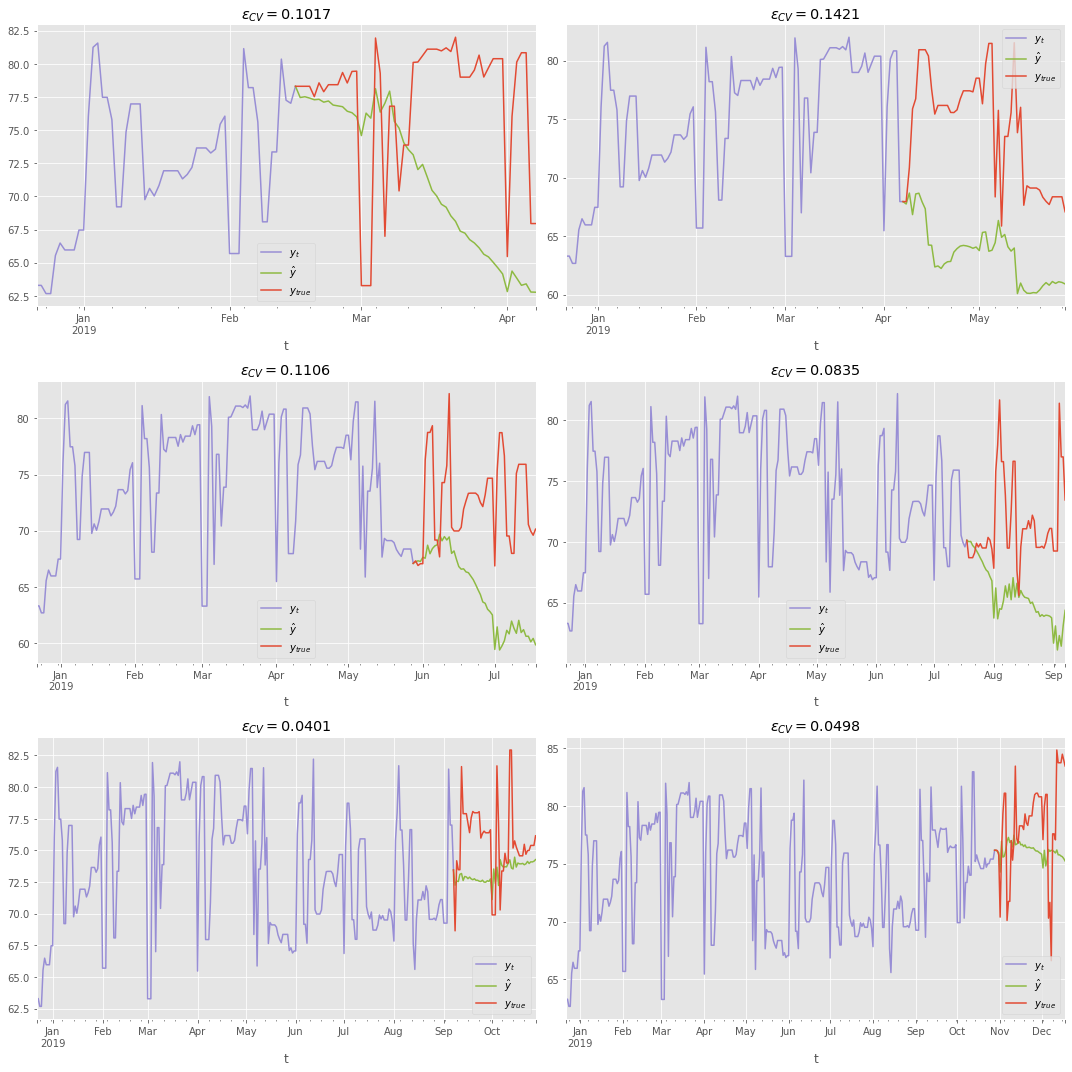

In [47]:
gc = stb.GeneralCalibrator(sm.RLM, dict())
gm = stb.GeneralModel(gc, DM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run()

## Residuals (standardized) Diagnostics

$$
\hat{\varepsilon}_t = v_{{t}}-\hat{v}_t; \ \hat{\varepsilon}_t^{std}; \ \hat{\varepsilon}_t^{stu}
$$

$$
\text{RD} = \mathcal{RD}(\hat{\varepsilon}_t, \hat{\varepsilon}_t^{std}, \hat{\varepsilon}_t^{stu}  )
$$

In [48]:
gc = stb.GeneralCalibrator(sm.tsa.arima.ARIMA, 
                               dict(order=(1,0,1), 
                               trend='n', 
                               enforce_stationarity=True))
gm = stb.GeneralModel(gc, DM)

In [49]:
gm.fit(range(DM.n-4))

In [50]:
gm.forecast(range(DM.n-4))

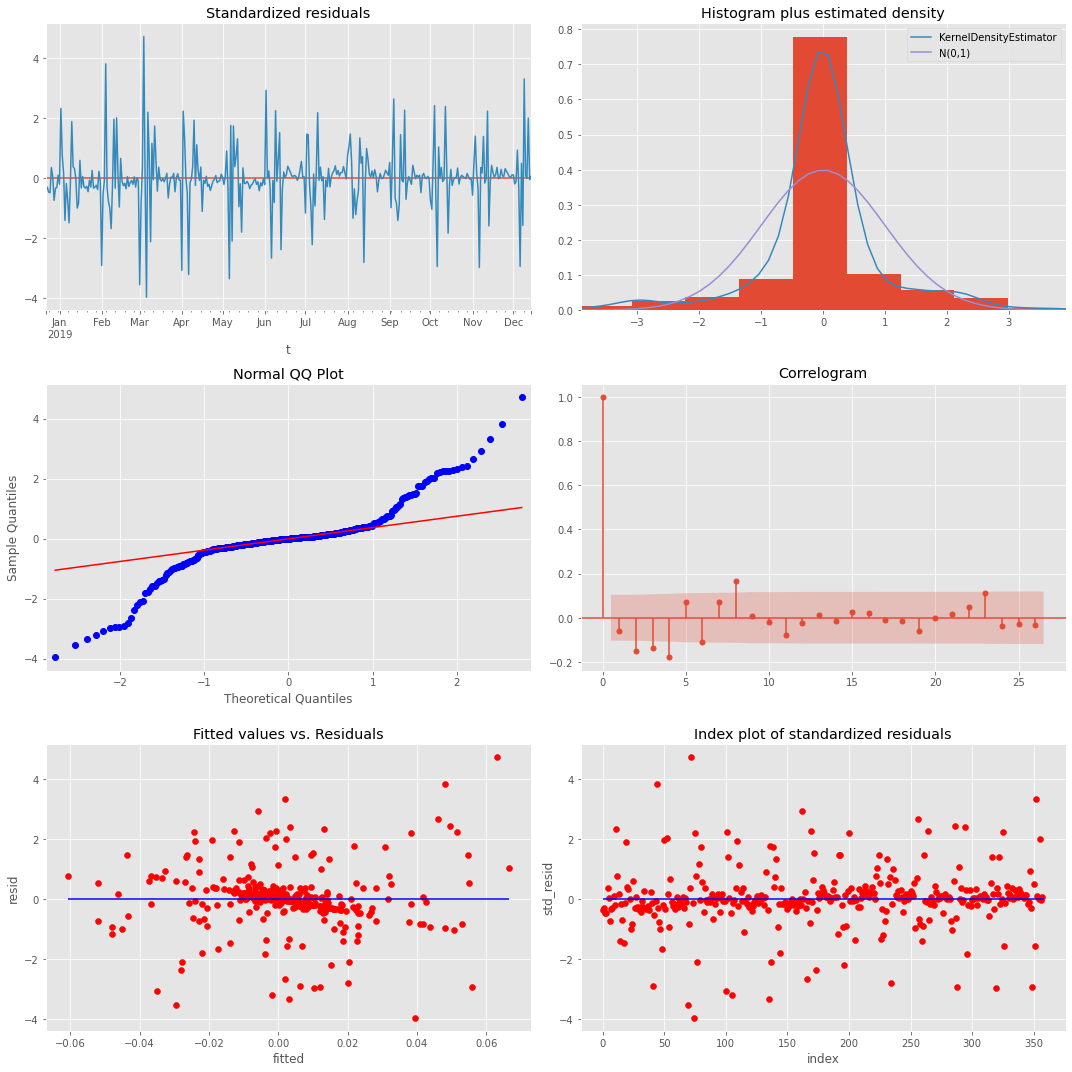

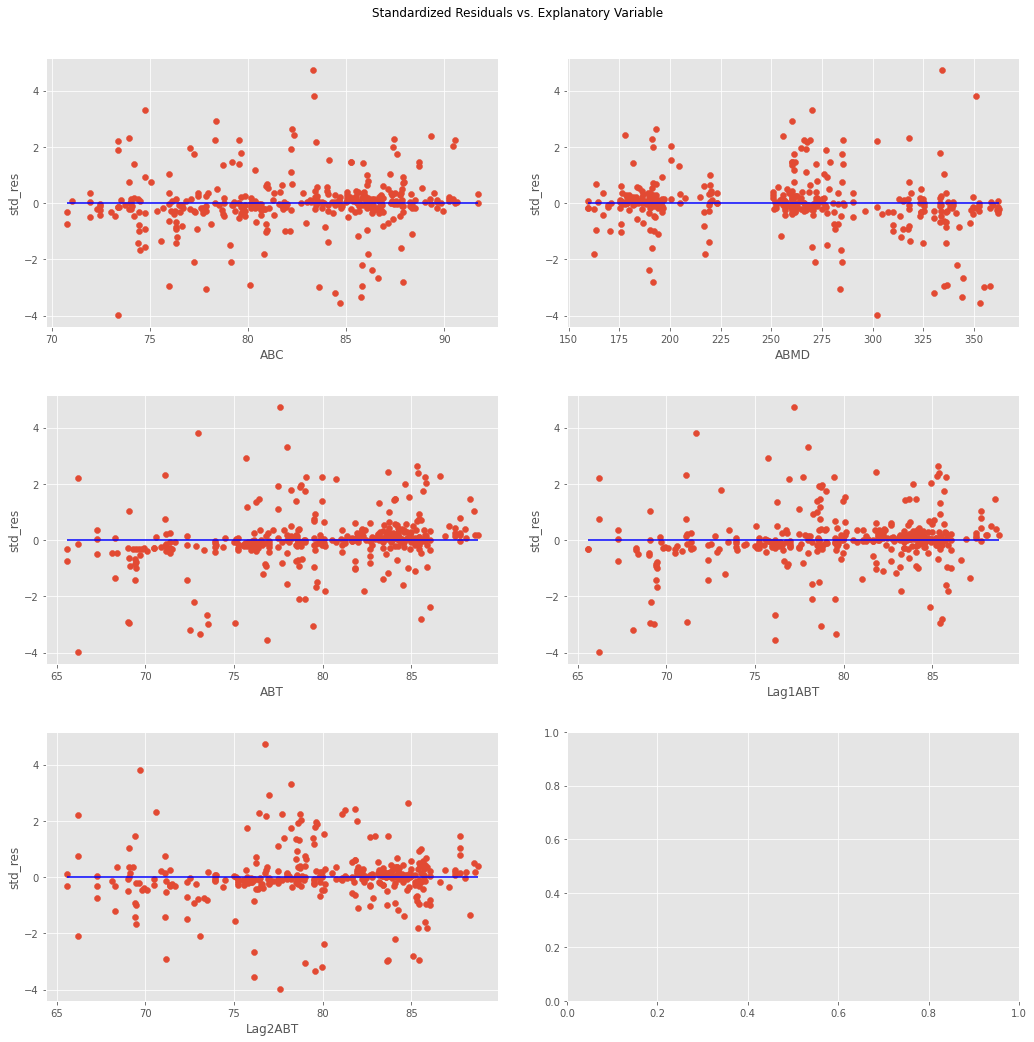

In [51]:
gm.plot_diagnostics()